# Find the partial correlations between each priming group in all stories and the loc template, soc template, and story vectors

## similar to anaylis 26:
#### each participants' recall is kept independent until after the regression and correlation, thereafter the mean is taken across subjects

## different from the other analyses:
### L_corr = corr(L, recall - story)
### S_corr = corr(S, recall - story)
### story_corr = corr(story, recall - L - S - other stories with shared schema)
### ) all other possible regressors besides the regressor used in the correlation are used in the initial regression

## 2/18/20


#### In this analysis:
#### we are starting with the participant recalls for each story separated by priming group. 
#### For each participant, we get the correlation value for it and the story wv, the location schema wv, and the social schema wv after regressing out from each participant other wvs specific to that correlation. 
#### ex. for the social schema wv, and only the story vector is used in the regression
#### We avg within priming group and correlation type, so that all of the social primed participants have their story correlations avg'd etc. 

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import pickle
import copy
from random import randrange
from sklearn.metrics import jaccard_score
import random
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from scipy import stats


from sklearn.decomposition import PCA #for cluster analysis
import matplotlib.pyplot as plt #for plotting
import os #for importing
import pickle #for loading transcripts
from scipy.stats import pearsonr 

# from _DRAFT_20200604_functions import * #includes constants and score function
from tqdm import tqdm_notebook #for progress bar

%autosave 5

Autosaving every 5 seconds


# 0. Importing story and template vectors and sums 

In [2]:
templates = pickle.load( open( 'c_template', "rb" ) )
recalls = pickle.load( open( 'c_recall', "rb" ) )
stories = pickle.load( open( 'c_stories', "rb" ) )
# sums
sums = pickle.load( open( "new_sums", "rb" ) )

# I. Main analysis
## A. Getting the residuals + correlatons for each participant
### 1. Loc wv correlations

In [3]:
# Partial correlation with loc: regress out story wv, and correlate with loc

schema_order = [1, 2, 3, 4, 10, 20, 30, 40]
corrs = {}
count = 0
key_check =0 

for key in recalls:
    loc = key%10
    # Make the inputs of the regression
    new_input = stories[key].reshape(stories[key].shape[0],-1)
    for prime in range(0,3):
        all_subjs = np.zeros((0,3))
        for subj in range(0, len(recalls[key][prime])):
            ## regression 
            output = np.copy(recalls[key][prime][subj])
            #output = output.reshape(output.shape[0],-1)
            model = LinearRegression().fit(new_input, output)
            ## Is subtracting the intercept correct?? 
            new_vec = output - np.dot(model.coef_, new_input.T)- model.intercept_
            ## correlation
            # reshaping residuals
            new_vec = new_vec.reshape(new_vec.shape[0],-1)
            # correlation vector
            this_loc = templates[loc].reshape(templates[loc].shape[0],-1)
            # corrcoef function
            this_correl = np.corrcoef(this_loc.T, new_vec.T)[0,1]
            # placing this_correl in a 1 x 3 array
            subj_vec = np.array([this_correl, 0, 0])
            all_subjs = np.vstack((all_subjs, subj_vec))
        if key_check == 0:
            key_check = 1
            corrs[key] = {prime:all_subjs}
        else:
            corrs[key][prime] = all_subjs
    key_check = 0

### 4. Soc wv correlations

In [4]:
for key in recalls:
    soc = round(key/10)*10
        # Make the inputs of the regression
    new_input = stories[key].reshape(stories[key].shape[0],-1)
    for prime in range(0,3):
        all_subjs = np.zeros((0,3))
        for subj in range(0, len(recalls[key][prime])):
            ## regression 
            output = np.copy(recalls[key][prime][subj])
            #output = output.reshape(output.shape[0],-1)
            model = LinearRegression().fit(new_input, output)
            ## Is subtracting the intercept correct?? 
            new_vec = output - np.dot(model.coef_, new_input.T)- model.intercept_
            ## correlation
            # reshaping residuals
            new_vec = new_vec.reshape(new_vec.shape[0],-1)
            # correlation vector
            this_soc = templates[soc].reshape(templates[soc].shape[0],-1)
            # corrcoef function
            this_correl = np.corrcoef(this_soc.T, new_vec.T)[0,1]
            # placing this_correl in the 1 x 3 array
            corrs[key][prime][subj, 1] = this_correl

### 5. Story correlations

In [5]:
story_order = [11,12,13,14,21,22,23,24,31,32,33,34,41,42,43,44]

for key in recalls:
    loc = key%10
    soc = round(key/10)*10
    # location template
    l_temp = templates[loc].reshape(templates[loc].shape[0],-1)
    # social template
    s_temp = templates[soc].reshape(templates[soc].shape[0],-1)
    inputs = np.concatenate((l_temp, s_temp), axis = 1)
    # List the set of stories that share a schema with the stories
    shared_schema = []
    for story in story_order:
        this_loc = story%10
        this_soc = round(story/10)*10
        if story == key:
            pass
        elif this_loc == loc:
            shared_schema.append(story)
        elif this_soc == soc:
            shared_schema.append(story)
        else:
            shared_schema.append(story)
    # Iterate through the list
    for story in shared_schema:
        inputs = np.concatenate((inputs, stories[story].reshape(stories[story].shape[0],-1)), axis = 1)
    print(inputs.shape)
    for prime in range(0,3):
        all_subjs = np.zeros((0,3))
        for subj in range(0, len(recalls[key][prime])):
            ## regression 
            output = np.copy(recalls[key][prime][subj])
            #output = output.reshape(output.shape[0],-1)
            model = LinearRegression().fit(inputs, output)
            ## Is subtracting the intercept correct?? 
            new_vec = output - np.dot(model.coef_, inputs.T)- model.intercept_
            ## correlation
            # reshaping residuals
            new_vec = new_vec.reshape(new_vec.shape[0],-1)
            # correlation vector
            this_story = stories[key].reshape(stories[key].shape[0],-1)
            # corrcoef function
            this_correl = np.corrcoef(this_story.T, new_vec.T)[0,1]
            # placing this_correl in the 1 x 3 array
            corrs[key][prime][subj, 2] = this_correl

(300, 17)
(300, 17)
(300, 17)
(300, 17)
(300, 17)
(300, 17)
(300, 17)
(300, 17)
(300, 17)
(300, 17)
(300, 17)
(300, 17)
(300, 17)
(300, 17)
(300, 17)
(300, 17)


## C. Avg 3 types of correlations across all stories for each priming type

In [6]:
avg_corr = {}

for i in range(0,3):
    this_prime = np.zeros((0,3))
    # concat corrs from all stories
    for key in story_order:
        this_prime = np.vstack((this_prime, corrs[key][i]))
    # avg down the rows
    print(this_prime.shape)
    avg_prime = np.mean(this_prime, axis = 0)
    print(avg_prime.shape)
    # put into dict
    avg_corr[i] = avg_prime
        

(103, 3)
(3,)
(108, 3)
(3,)
(104, 3)
(3,)


In [7]:
avg_corr

{0: array([0.11973587, 0.08761293, 0.02426309]),
 1: array([0.18386736, 0.08081887, 0.02476534]),
 2: array([0.13833077, 0.04842306, 0.02824094])}

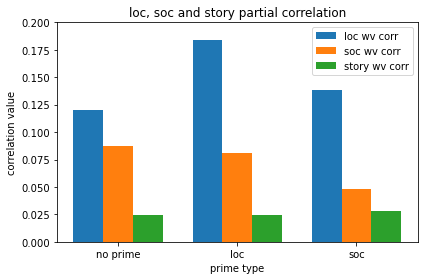

In [8]:
# loc weight
w0 = np.zeros((3,1))

# soc weight
w1 = np.zeros((3,1))

# story weight
w2 = np.zeros((3,1))

# assign values
w0[0] = avg_corr[0][0]
w0[1] = avg_corr[1][0]
w0[2] = avg_corr[2][0]

w1[0] = avg_corr[0][1]
w1[1] = avg_corr[1][1]
w1[2] = avg_corr[2][1]

w2[0] = avg_corr[0][2]
w2[1] = avg_corr[1][2]
w2[2] = avg_corr[2][2]


w0 = w0.ravel()
w1 = w1.ravel()
w2 = w2.ravel()

#labels
labels = ['no prime', 'loc', 'soc']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x, w0, width, label='loc wv corr')
rects2 = ax.bar(x + width, w1, width, label='soc wv corr')
rects3 = ax.bar(x + width*2, w2, width, label='story wv corr')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('correlation value')
ax.set_xlabel('prime type')
ax.set_title('loc, soc and story partial correlation')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim([0, .2])
fig.tight_layout()

plt.show()


